# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [28]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data' # specify the output directory of the processing should be the same in every notebook
test = 'Esophagus_146_0.01' # sample name, this should be the same for all the notebooks

## QC Settings

In [67]:
# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary

############################# filters ##########################################

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = False

# Filter to use:

# Decide whether to remove doublets using scrublet (True) or to skip doublet calculation (False)
filter_doublets = False
use_native_scrublet = True
threads = 2
doublet_threshold = 0.2
use_condition_column = False
condition_doublet_removal = None

# True or False; filtering out cells with numbers of features not in the range defined below
n_features_filter = True
# True or False; filtering out cells with mean insertsize not in the range defined below
mean_insertsize_filter = True
# True or False; filtering out cells with mean insertsize not in the range defined below
nucleosomal_score_momentum_filter = True
# True or False; filtering out cells with mean insertsize not in the range defined below
nucleosomal_score_cwt_filter = True
# True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_pct_fp= False
# True or False; filtering out cells with a number features in chromosome M not in the defined range
filter_chrM_fragments= False
# True or False; filtering out cells with fragments mapped not in the defined range
filter_uniquely_mapped_fragments= False


# if this is True thresholds below are ignored 
only_automatic_thresholds = False # True or False; to use automatic thresholds

############################# set default values #######################################
# 
# This will be applied to all samples the thresholds can be changed manually when plotted 
# if thresholds None they are set automatically

# default values n_features 
min_features = 100
max_features = 5000

# default mean_insertsize
upper_threshold_mis=None
lower_threshold_mis=None

# nucleosomal_score_momentum
upper_threshold_nsm=None
lower_threshold_nsm=None

# nucleosomal_score_cwt
upper_threshold_nscwt=None
lower_threshold_nscwt=None

# default promotor enrichment
upper_threshold_pct_fp=None
lower_threshold_pct_fp=None

# default number of fragments
upper_thr_fragments=None
lower_thr_fragments=None

# default number of fragments in chrM
upper_thr_chrM_fragments=1000
lower_thr_chrM_fragments=0

# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [87]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['n_features_by_counts'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if nucleosomal_score_momentum_filter:
    manual_thresholds['nucleosomal_score_momentum'] = {'min' : lower_threshold_nsm, 'max' : upper_threshold_nsm}
    
if nucleosomal_score_cwt_filter:
    manual_thresholds['nucleosomal_score_cwt'] = {'min' : lower_threshold_nscwt, 'max' : upper_threshold_nscwt}
    
if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}

obs_columns = list(manual_thresholds.keys())

## Loading packages and setup

In [88]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
import sctoolbox.qc_filter as qc
import sctoolbox.plotting as pl
import sctoolbox.atac_utils as atac_utils
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np
import scrublet as scr

## Setup path handling object 

In [89]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [90]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 73652 × 174262
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'Sample_new', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nucleosomal_score_momentum', 'nucleosomal_score_cwt', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'legend'

# QC

## 1. filtering out chrX, chrY and chrM

In [93]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [94]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [95]:
display(adata)

View of AnnData object with n_obs × n_vars = 73652 × 169256
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'Sample_new', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nucleosomal_score_momentum', 'nucleosomal_score_cwt', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'legend'

## 2. removing empty cells

In [96]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 71715 × 166856
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'Sample_new', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nucleosomal_score_momentum', 'nucleosomal_score_cwt', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'color_set', 'infoprocess', 'legend'

## 3. binarize

In [97]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 4. doublet removal

In [98]:
adata.uns["infoprocess"]["plot_metrics"] = []

In [99]:
 if filter_doublets:
        
    if use_condition_column:
        condition_doublet_removal = condition_column
    
    if use_native_scrublet:
        # TODO: Implement Wrapper function for sctoolbox
        adata.obs['doublet_score'] = float('NaN')
        adata.obs['predicted_doublet'] = None

        sample_dict = {}
        for sample in adata.obs[condition_column].unique():
            print('Run scrublet for condition: ' + sample)
            X = adata.X[adata.obs[condition_column] == sample]
            scrub = scr.Scrublet(X)
            doublet_scores, predicted_doublets = scrub.scrub_doublets()
            adata.obs.loc[adata.obs[condition_column]==sample, 'doublet_score'] = doublet_scores
            adata.obs.loc[adata.obs[condition_column]==sample, 'predicted_doublet'] = predicted_doublets
            
        adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype(bool)
        
    else:
        qc.estimate_doublets(adata, groupby=condition_doublet_removal, threads=threads, threshold=doublet_threshold)
    
    #Remove the duplicates from adata
    qc.filter_cells(adata, "predicted_doublet", remove_bool=True)
    
    #Save to adata to plot later on
    adata.uns["infoprocess"]["plot_metrics"].append("doublet_score")

In [100]:
adata.obs

,TN,UM,PP,UQ,CM,file,sample,Sample_new,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize,nucleosomal_score_momentum,nucleosomal_score_cwt,n_fragments_in_promoters,pct_fragments_in_promoters,nb_features,log_nb_features
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,5,1.791759,5.0,1.791759,16.0,79.05,0.001991,0.000000,4.0,0.285714,4,0.602060
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,17,2.890372,17.0,2.890372,34.0,161.66,0.000000,0.000000,5.0,0.178571,16,1.204120
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,10,2.397895,10.0,2.397895,12.0,152.17,0.000000,0.000000,5.0,0.357143,10,1.000000
AAACTACCAGAAACGTCCCGTT,6223.0,5231.0,5213.0,3779.0,18.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,1648,7.407924,1791.0,7.491087,5185.0,134.30,0.000000,0.000000,1307.0,0.247679,1616,3.208441
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,13,2.639057,13.0,2.639057,13.0,154.92,0.911111,0.142669,8.0,0.320000,12,1.079181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGAAGAAGG,16.0,11.0,11.0,10.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,5,1.791759,5.0,1.791759,11.0,182.18,0.510909,0.000000,1.0,0.111111,5,0.698970
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,3,1.386294,3.0,1.386294,6.0,117.17,0.003061,0.000000,1.0,0.250000,3,0.477121
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,3,1.386294,3.0,1.386294,4.0,58.50,0.002586,0.000000,0.0,0.000000,3,0.477121
TTCCATCCTCTTTGCCGGAAGG,8.0,7.0,7.0,7.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,5,1.791759,5.0,1.791759,2.0,154.50,0.007500,0.000000,1.0,0.200000,5,0.698970


## 5. visualize adata

In [101]:
adata.var

,peak_chr,peak_start,peak_end,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
chr1:10005-10731,chr1,10005,10731,410,0.005811,0.005794,99.443328,428.0,6.061457,410
chr1:28730-29439,chr1,28730,29439,22,0.000299,0.000299,99.970130,22.0,3.135494,22
chr1:91328-91482,chr1,91328,91482,6,0.000081,0.000081,99.991854,6.0,1.945910,6
chr1:139088-139266,chr1,139088,139266,3,0.000054,0.000054,99.995927,4.0,1.609438,3
chr1:180710-182007,chr1,180710,182007,568,0.008499,0.008464,99.228806,626.0,6.440947,568
...,...,...,...,...,...,...,...,...,...,...
chr9:138209358-138209542,chr9,138209358,138209542,8,0.000109,0.000109,99.989138,8.0,2.197225,8
chr9:138209601-138209830,chr9,138209601,138209830,1,0.000014,0.000014,99.998642,1.0,0.693147,1
chr9:138213762-138214121,chr9,138213762,138214121,43,0.000597,0.000597,99.941617,44.0,3.806663,43
chr9:138215567-138215868,chr9,138215567,138215868,3,0.000041,0.000041,99.995927,3.0,1.386294,3


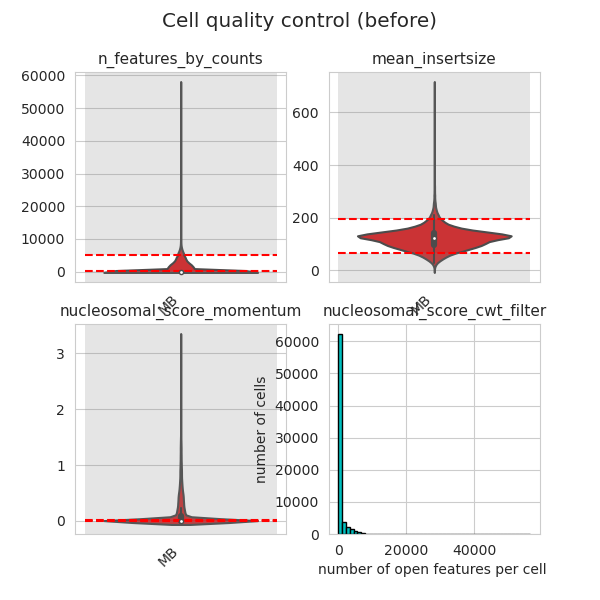

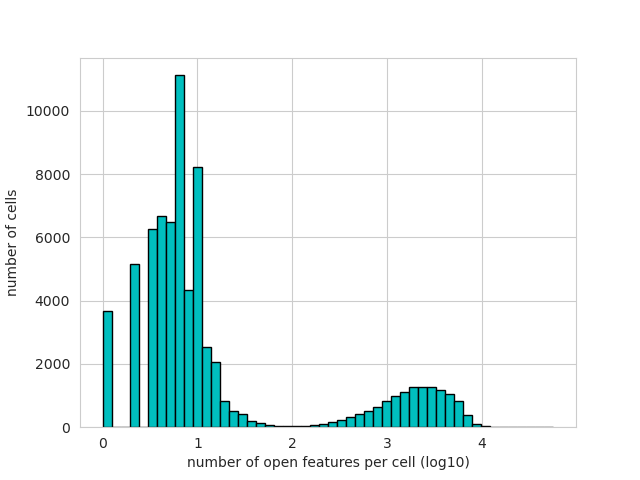

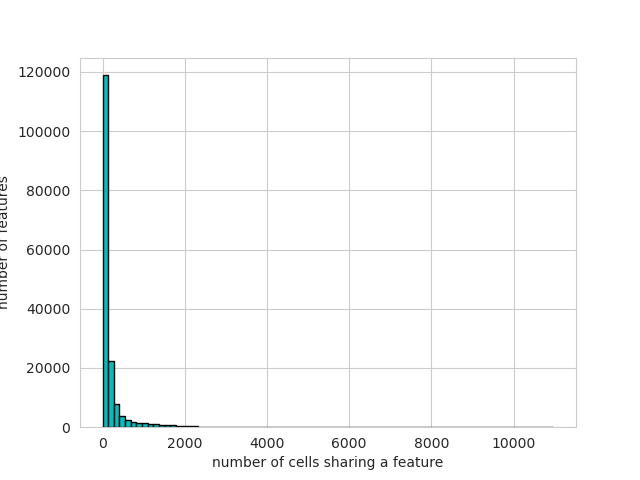

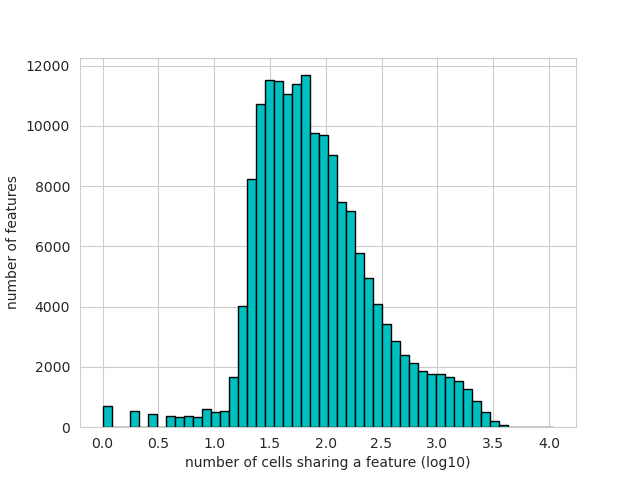

In [102]:
# plot_ov_hist(adata, threshold_features=50) 
epi.pp.filter_features(adata, min_cells=1)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50)

epi.pp.coverage_features(adata, binary=True, log=False, bins=50)
epi.pp.coverage_features(adata, binary=True, log=10, bins=50)

## 6. Cells Filtering

### 6.1 get thresholds dict

In [103]:
groupby = condition_column if global_threshold is False else None
thresholds = atac_utils.get_thresholds_atac_wrapper(adata, manual_thresholds, only_automatic_thresholds, groupby=groupby)
qc.thresholds_as_table(thresholds)

,Parameter,Group,Minimum,Maximum
0,n_features_by_counts,MB,100.000000,5000.000000
1,mean_insertsize,MB,67.881737,196.038397
2,nucleosomal_score_momentum,MB,-0.006865,0.010229
3,nucleosomal_score_cwt,MB,-0.003020,0.003034


### 6.2 plot thresholds

In [105]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
obs_figure, obs_slider_dict = qc.quality_violin(adata, columns=obs_columns,
                                            groupby=condition_column,
                                            which="obs",
                                            thresholds=thresholds,
                                            global_threshold=global_threshold,
                                            title="Cell quality control (before)",
                                            save=tree.qc_plots + "cell_filtering.png")
obs_figure

In [107]:
# Get final thresholds
final_thresholds = qc.get_slider_thresholds(obs_slider_dict)
qc.thresholds_as_table(final_thresholds) # show thresholds

,Parameter,Minimum,Maximum
0,n_features_by_counts,100.000000,5000.000000
1,mean_insertsize,67.881737,196.038397
2,nucleosomal_score_momentum,0.000000,0.400000
3,nucleosomal_score_cwt,0.000000,0.200000


### 6.3 filter adata

In [108]:
qc.apply_qc_thresholds(adata, final_thresholds, groupby=groupby)
# remove empty features
epi.pp.filter_features(adata, min_cells=1)

Filtering based on 'n_features_by_counts' from 71715 -> 11406 cells
Filtering based on 'mean_insertsize' from 11406 -> 11404 cells
Filtering based on 'nucleosomal_score_momentum' from 11404 -> 11403 cells
Filtering based on 'nucleosomal_score_cwt' from 11403 -> 9364 cells


In [109]:
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 9364 × 166474
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'Sample_new', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nucleosomal_score_momentum', 'nucleosomal_score_cwt', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness'
    uns: 'color_set', 'infoprocess', 'legend'
    layers: 'binary'

## 7. save plots

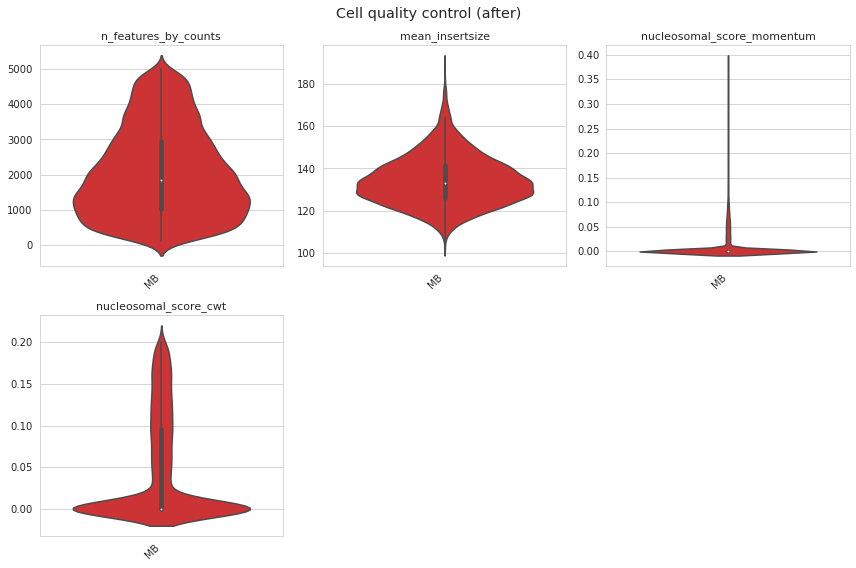

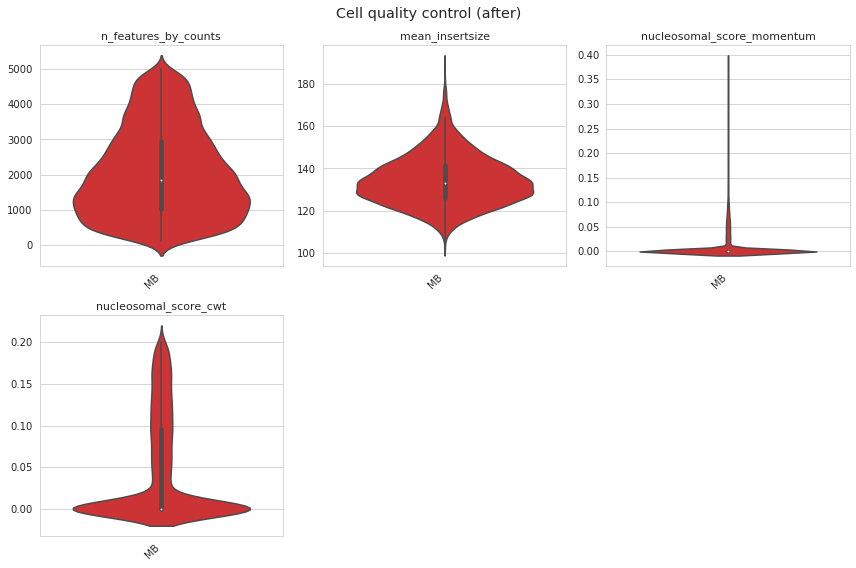

In [110]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = qc.quality_violin(adata, columns=obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=tree.qc_plots + "cell_filtering_final.png")
figure 

## 8. save anndata

In [111]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)

In [112]:
tree.qc_dir

'/mnt/workspace/jdetlef/processed_data/Esophagus_146_0.01/qc'

In [113]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '02_QC.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.qc_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)

'/mnt/workspace/jdetlef/processed_data/Esophagus_146_0.01/qc/02_QC.ipynb'